<a href="https://colab.research.google.com/github/gjduart/NN/blob/main/CNN_EX3_NN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aluno: Gabriel Jonas da Silva Duarte, </br >
       Mayanna Rodrigues Ferreira


Realizando as importações das bibliotecas que iremos utilizar

In [ ]:
import numpy as np
from matplotlib import pyplot as plt


import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms


Durante o desenvolvimento desse codigo tivemos um imprevisto com o mnist pois não conseguimos fazer o download torchvision devido a instabilidade nos servidores, como alternativa utilizamos o EMNIST onde podemos passar como parametro (split='mnist') para usar somente o dataset mnist.

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

train_set = datasets.EMNIST('DATA_MNIST/', download=True, train=True, transform=transform, split="mnist")
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.EMNIST('DATA_MNIST/', download=True, train=False, transform=transform,split='mnist')
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Checando o shape das imagens e das labels, para os parâmetros do nosso modelo.

In [ ]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) 
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Iremos realizar ao longo do nosso modelo um pequeno calculo para determinar o valor para o redout:

$$out_{conv} = \frac{x_{input} + 2* padding - Kernel}{stride} $$

In [ ]:
class CNNmodel(nn.Module):

    def __init__(self, input_channel,Nout_features,kernel_size=1,padding=0,stride=1):
        super(CNNmodel, self).__init__()
        # Convolutional Neural Network Layer 
        self.CNNmodel= nn.Sequential(
                
                nn.Conv2d(input_channel, out_channels=Nout_features, kernel_size=kernel_size, padding=padding, stride=stride),      # (N, 1, 28, 28) 
                nn.ReLU(),                                                                                                          # out = (28 + 2*1 - 3)/1 = 28
                nn.MaxPool2d(kernel_size=2),                                                                                        # out = out/kernel_size_{maxpool}   
                nn.Conv2d(in_channels=Nout_features, out_channels=2*Nout_features, kernel_size=kernel_size, padding=padding, stride=stride),     # out = (out + 2*1 - 3)/1 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2) 
                                                                                                                                    # out = (out/kernel_size{maxpool})
                
                
        )

       
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=2*Nout_features * 7 * 7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), #dropout com p=0.2 para evitar overfitting
                nn.Linear(in_features=64, out_features=10) 
                #out_features => numero de classes 
        )

    def forward(self, x):
        x = self.CNNmodel(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear_layers(x)
        return x

Vamos verificar nosso dispositivo, para usar no treinamento.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Iremos definir o nosso modelo, o canal de entrada será 1 pois o nosso dataset esttá todo em grayscale, e para os canais de saída 12

In [ ]:
model = CNNmodel(1,12)
model = model.to(device)

Definimos o nosso otimizador e o criterio para calcular nossa função custo


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Treinamento

In [ ]:

num_epochs = 100 #Numero de epocas
total_step = len(trainLoader)  #o Tamanho do passo
loss_list = []
acc_list = []
for epoch in range(num_epochs):  
    for i, (images, labels) in enumerate(trainLoader):
        images = images.to(device)     #Convertendo as imagens para CUDA
        labels =  labels.to(device)    #Convertando labels para CUDA
        # forward
        outputs = model(images)            
        loss = criterion(outputs, labels)   #Computando o custo
        
        # Backprop 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    loss_list.append(loss.item())

Epoch [1/100], Step [100/938], Loss: 2.2598, Accuracy: 23.44%
Epoch [1/100], Step [200/938], Loss: 2.1121, Accuracy: 50.00%
Epoch [1/100], Step [300/938], Loss: 1.6234, Accuracy: 65.62%
Epoch [1/100], Step [400/938], Loss: 0.9125, Accuracy: 75.00%
Epoch [1/100], Step [500/938], Loss: 0.6595, Accuracy: 73.44%
Epoch [1/100], Step [600/938], Loss: 0.4897, Accuracy: 87.50%
Epoch [1/100], Step [700/938], Loss: 0.6756, Accuracy: 81.25%
Epoch [1/100], Step [800/938], Loss: 0.5316, Accuracy: 84.38%
Epoch [1/100], Step [900/938], Loss: 0.5777, Accuracy: 79.69%
Epoch [2/100], Step [100/938], Loss: 0.6097, Accuracy: 84.38%
Epoch [2/100], Step [200/938], Loss: 0.4739, Accuracy: 85.94%
Epoch [2/100], Step [300/938], Loss: 0.4850, Accuracy: 85.94%
Epoch [2/100], Step [400/938], Loss: 0.3330, Accuracy: 90.62%
Epoch [2/100], Step [500/938], Loss: 0.2774, Accuracy: 87.50%
Epoch [2/100], Step [600/938], Loss: 0.3793, Accuracy: 87.50%
Epoch [2/100], Step [700/938], Loss: 0.3706, Accuracy: 85.94%
Epoch [2

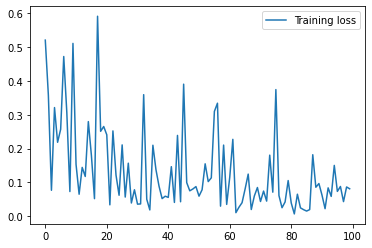

In [ ]:
plt.plot(loss_list, label='Training loss')
#plt.plot(val_loss, label='Test loss',color='r')
plt.legend()
plt.show()

In [ ]:
total_val_loss

0.09282496700062282

# CIFAR 10


Agora iremos utilizar o CIFAR10, ele possui três canais.

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# Download and load the training data
train_set = datasets.CIFAR10('DATA_CIFA10/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR10/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Extracting DATA_CIFA10/cifar-10-python.tar.gz to DATA_CIFA10/


Extracting DATA_CIFAR10/cifar-10-python.tar.gz to DATA_CIFAR10/


In [ ]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) 
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [ ]:
class CNNmodel(nn.Module):

    def __init__(self, input_channel,Nout_features,kernel_size=1,padding=0,stride=1):
        super(CNNmodel, self).__init__()
        # Convolutional Neural Network Layer 
        self.CNNmodel= nn.Sequential(
            
                nn.Conv2d(input_channel, out_channels=Nout_features, kernel_size=1, padding=0, stride=1),    
                nn.ReLU(),                                                                          
                nn.MaxPool2d(kernel_size=2),                                                         
                nn.Conv2d(in_channels=32, out_channels=2*Nout_features, kernel_size=1, padding=0, stride=1),      
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2) 
                                                                        
                
                
        )

       
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=2*Nout_features * 8 * 8, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), #dropout com p=0.2 para evitar overfitting
                nn.Linear(in_features=64, out_features=10) 
                #out_features => numero de classes 
        )

    def forward(self, x):
        x = self.CNNmodel(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear_layers(x)
        return x

Definindo funções para facilitar nosso treino 

In [ ]:
def train(model,images,labels,criterion,optimizer):
      
      optimizer.zero_grad()  # Limpa os gradientes do otimizador
      outputs = model(images)  # Realiza um passo do forward
      loss = criterion(outputs, labels)  # Computa a loss baseado nos nós de treinamento.
      loss.backward()  # Deriva os gradients.
      optimizer.step()  # atualiza os parametros.
      return loss



@torch.no_grad()
def test(model,images,labels):
      model.eval()
      outputs = model(images)
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      
      return correct / total



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
input_channel = 3
Nft_out = 32


model = CNNmodel(input_channel,Nft_out)
model = model.to(device)
model

CNNmodel(
  (CNNmodel): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time 

start_time = time.time()

criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr = 0.01, weight_decay=5e-4)
loss = []
total_loss = []
#comparando_loss = []
for epoch in range(1,21):
  model.train()    
  t = time.time()

  for i, (images, labels) in enumerate(trainLoader,0):
    
    images = images.to(device)
    labels =  labels.to(device)
    train_loss = train(model,images,labels,criterion, opt)
    test_acc = test(model,images,labels)
    loss.append(train_loss.item())
  total_loss.append(train_loss)
  
  print(f'Epoca:{epoch}, Loss: {train_loss:.3f}, acc_train:{test_acc*100}%,  tempo:{time.time() - t:.3f}')

#comparando_loss.append(loss)      
print(f'Tempo total:{time.time() - start_time}')
 

Epoca:1, Loss: 2.042, acc_train:43.75%,  tempo:12.782
Epoca:2, Loss: 1.925, acc_train:31.25%,  tempo:12.185
Epoca:3, Loss: 1.541, acc_train:75.0%,  tempo:12.189
Epoca:4, Loss: 1.596, acc_train:50.0%,  tempo:11.758
Epoca:5, Loss: 1.084, acc_train:68.75%,  tempo:12.081
Epoca:6, Loss: 0.952, acc_train:87.5%,  tempo:12.274
Epoca:7, Loss: 1.513, acc_train:56.25%,  tempo:12.136
Epoca:8, Loss: 1.434, acc_train:56.25%,  tempo:11.755
Epoca:9, Loss: 1.360, acc_train:56.25%,  tempo:11.845
Epoca:10, Loss: 0.756, acc_train:75.0%,  tempo:12.216
Epoca:11, Loss: 1.038, acc_train:68.75%,  tempo:11.850
Epoca:12, Loss: 1.586, acc_train:56.25%,  tempo:12.192
Epoca:13, Loss: 1.331, acc_train:75.0%,  tempo:11.542
Epoca:14, Loss: 1.248, acc_train:56.25%,  tempo:12.026
Epoca:15, Loss: 1.289, acc_train:62.5%,  tempo:12.016
Epoca:16, Loss: 1.214, acc_train:68.75%,  tempo:11.474
Epoca:17, Loss: 1.139, acc_train:62.5%,  tempo:12.005
Epoca:18, Loss: 1.331, acc_train:75.0%,  tempo:11.772
Epoca:19, Loss: 1.295, acc_

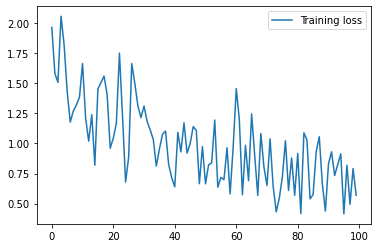

In [ ]:
plt.plot(loss, label='Training loss')
#plt.plot(val_loss, label='Test loss',color='r')
plt.legend()
plt.show()